In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from PIL import Image
import torch.nn.functional as F
import os
import sys
from tqdm import tqdm
import torch
import numpy as np

sys.path.append(os.path.dirname('./ml/tio_dataset'))
sys.path.append(os.path.dirname('./ml/models'))
sys.path.append(os.path.dirname('./ml/metrics'))
sys.path.append(os.path.dirname('./ml/utils'))
sys.path.append(os.path.dirname('./ml/models/activates'))
sys.path.append(os.path.dirname('./ml/models.building_blocks'))

In [20]:
from models.ResUnet import ResUNet, ResUNet2d
from models.unet_deepsup import Unet_MSS
from models.DiffusionUnet import UNet


from tio_dataset import TioDataset

from utils import weights_init_normal_and_zero_bias, print_imgs_grid
from IPython.display import clear_output

In [21]:
def img_to_tensor(im):
    return im.permute(2, 0, 1)

def tensor_to_image(t):
    return t.permute(1, 2, 0)

def gather(consts: torch.Tensor, t: torch.Tensor):
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)


def q_xt_x0(x0, t, with_noise=True):
    mean = gather(alpha_bar, t) ** 0.5 * x0 # теперь alpha_bar
    var = 1-gather(alpha_bar, t) # (1-alpha_bar)
    eps = torch.randn_like(x0)
    if with_noise:
        return mean + (var ** 0.5) * eps, eps
    else:
        return mean + (var ** 0.5) * eps
    
def p_xt(xt, noise, t):
    alpha_t = gather(alpha, t)
    alpha_bar_t = gather(alpha_bar, t)
    eps_coef = (1 - alpha_t) / (1 - alpha_bar_t) ** .5
    mean = 1 / (alpha_t ** 0.5) * (xt - eps_coef * noise)
    var = gather(beta, t)
    eps = torch.randn(xt.shape, device=xt.device)
    return mean + (var ** 0.5) * eps 

**<h3> Medical**

In [22]:
batch_size = 64
train_settings  = {
    "patch_shape" : (64, 64, 1),
    "patches_per_volume" : 512,
    "patches_queue_length" : 2048,
    "batch_size" : batch_size,
    "num_workers": 4,
    "sampler": "weighted" #"uniform",#
}

data_dir = "/home/msst/Documents/medtech/data/GAN_MRA_train"
dataset = TioDataset(data_dir,
                 train_settings=train_settings,
                 val_settings=None,
                 test_settings=None)

In [23]:
n_steps = 250
beta = torch.linspace(0.0001, 0.04, n_steps).cuda()
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

In [24]:
unet = UNet(image_channels = 1, n_channels=32, n_blocks=4).cuda()
#unet = ResUNet().cuda()

lr = 3e-4
optim = torch.optim.AdamW(unet.parameters(), lr=lr)

In [25]:
history = []
for epoch in tqdm(range(10)):
    losses = []
    for batch in dataset.train_dataloader:
        x0 = batch['head']['data'].squeeze(-1).cuda()
        t = torch.randint(0, n_steps, (batch_size,), dtype=torch.long).cuda()
        xt, noise = q_xt_x0(x0, t)
        pred_noise = unet(xt.float(), t)
        loss = F.mse_loss(noise.float(), pred_noise)
        losses.append(loss.item())
        optim.zero_grad()
        loss.backward()
        optim.step()
    mean_loss = sum(losses)/len(losses)   
    print(mean_loss)
    history.append(mean_loss)  

  1%|▍                                        | 1/100 [00:41<1:08:12, 41.33s/it]

0.2970136646181345


  2%|▊                                        | 2/100 [01:22<1:07:44, 41.48s/it]

0.20788599317893386


  3%|█▏                                       | 3/100 [02:04<1:07:09, 41.54s/it]

0.18764190934598446


  4%|█▋                                       | 4/100 [02:46<1:06:31, 41.58s/it]

0.182690225308761


  5%|██                                       | 5/100 [03:27<1:05:48, 41.56s/it]

0.18081581767182797


  6%|██▍                                      | 6/100 [04:09<1:05:09, 41.59s/it]

0.17962306761182845


  7%|██▊                                      | 7/100 [04:51<1:04:30, 41.62s/it]

0.1783549466636032


  8%|███▎                                     | 8/100 [05:32<1:03:50, 41.63s/it]

0.17200567945837975


  9%|███▋                                     | 9/100 [06:14<1:03:09, 41.64s/it]

0.17270897375419736


 10%|████                                    | 10/100 [06:55<1:02:27, 41.64s/it]

0.17593397409655154


 11%|████▍                                   | 11/100 [07:37<1:01:44, 41.63s/it]

0.17059633939061314


 12%|████▊                                   | 12/100 [08:19<1:01:03, 41.63s/it]

0.173733975389041


 13%|█████▏                                  | 13/100 [09:00<1:00:21, 41.62s/it]

0.168629236984998


 14%|█████▉                                    | 14/100 [09:42<59:39, 41.63s/it]

0.1656811620341614


 15%|██████▎                                   | 15/100 [10:24<59:00, 41.65s/it]

0.17018871172331274


 16%|██████▋                                   | 16/100 [11:05<58:18, 41.64s/it]

0.16930050740484148


 17%|███████▏                                  | 17/100 [11:47<57:37, 41.65s/it]

0.16676413593813777


 18%|███████▌                                  | 18/100 [12:29<56:56, 41.66s/it]

0.16058861534111202


 19%|███████▉                                  | 19/100 [13:10<56:15, 41.67s/it]

0.16413052240386605


 20%|████████▍                                 | 20/100 [13:52<55:35, 41.69s/it]

0.1624454753473401


 21%|████████▊                                 | 21/100 [14:34<54:53, 41.69s/it]

0.1630944919306785


 22%|█████████▏                                | 22/100 [15:15<54:09, 41.67s/it]

0.16685576434247196


 23%|█████████▋                                | 23/100 [15:57<53:27, 41.66s/it]

0.1623300436185673


 24%|██████████                                | 24/100 [16:39<52:47, 41.68s/it]

0.1602620695484802


 25%|██████████▌                               | 25/100 [17:20<52:05, 41.67s/it]

0.16381036711391062


 26%|██████████▉                               | 26/100 [18:02<51:24, 41.68s/it]

0.1630248783621937


 27%|███████████▎                              | 27/100 [18:44<50:43, 41.69s/it]

0.16785218240693212


 28%|███████████▊                              | 28/100 [19:26<50:02, 41.70s/it]

0.18648891523480415


 29%|████████████▏                             | 29/100 [20:07<49:20, 41.70s/it]

0.16424649045802653


 30%|████████████▌                             | 30/100 [20:49<48:39, 41.70s/it]

0.16844474046956748


 31%|█████████████                             | 31/100 [21:31<47:57, 41.70s/it]

0.9424822493456304


 32%|█████████████▍                            | 32/100 [22:12<47:14, 41.68s/it]

0.999785085208714


 33%|█████████████▊                            | 33/100 [22:54<46:32, 41.68s/it]

1.0000411290675402


 34%|██████████████▎                           | 34/100 [23:36<45:50, 41.67s/it]

1.0002381326630712


 35%|██████████████▋                           | 35/100 [24:17<45:09, 41.69s/it]

1.0005316827446222


 36%|███████████████                           | 36/100 [24:59<44:27, 41.68s/it]

1.0003166068345308


 37%|███████████████▌                          | 37/100 [25:41<43:45, 41.67s/it]

1.0000839307904243


 38%|███████████████▉                          | 38/100 [26:22<43:04, 41.68s/it]

1.000101094134152


 39%|████████████████▍                         | 39/100 [27:04<42:21, 41.67s/it]

1.00014784373343


 40%|████████████████▊                         | 40/100 [27:46<41:40, 41.67s/it]

0.9993749121204019


 41%|█████████████████▏                        | 41/100 [28:27<40:58, 41.67s/it]

0.9998514326289296


 42%|█████████████████▋                        | 42/100 [29:09<40:16, 41.66s/it]

1.000588458031416


 43%|██████████████████                        | 43/100 [29:51<39:38, 41.72s/it]

1.0012091612443328


 44%|██████████████████▍                       | 44/100 [30:32<38:55, 41.70s/it]

0.999628477729857


 45%|██████████████████▉                       | 45/100 [31:14<38:13, 41.69s/it]

1.0000437637791038


 46%|███████████████████▎                      | 46/100 [31:56<37:31, 41.69s/it]

1.0004177605733275


 47%|███████████████████▋                      | 47/100 [32:37<36:48, 41.68s/it]

1.00023172236979


 48%|████████████████████▏                     | 48/100 [33:19<36:07, 41.68s/it]

0.9998397585004568


 49%|████████████████████▌                     | 49/100 [34:01<35:25, 41.67s/it]

0.9998530521988869


 50%|█████████████████████                     | 50/100 [34:42<34:43, 41.67s/it]

0.9997835801914334


 51%|█████████████████████▍                    | 51/100 [35:24<34:01, 41.66s/it]

0.9997910866513848


 52%|█████████████████████▊                    | 52/100 [36:06<33:19, 41.65s/it]

0.9997882666066289


 53%|██████████████████████▎                   | 53/100 [36:47<32:36, 41.64s/it]

nan


 54%|██████████████████████▋                   | 54/100 [37:29<31:55, 41.63s/it]

nan


 55%|███████████████████████                   | 55/100 [38:11<31:12, 41.62s/it]

nan


 56%|███████████████████████▌                  | 56/100 [38:52<30:30, 41.60s/it]

nan


 57%|███████████████████████▉                  | 57/100 [39:34<29:48, 41.60s/it]

nan


 58%|████████████████████████▎                 | 58/100 [40:15<29:06, 41.59s/it]

nan


 59%|████████████████████████▊                 | 59/100 [40:57<28:24, 41.57s/it]

nan


 60%|█████████████████████████▏                | 60/100 [41:38<27:43, 41.58s/it]

nan


 61%|█████████████████████████▌                | 61/100 [42:20<27:01, 41.57s/it]

nan


 62%|██████████████████████████                | 62/100 [43:02<26:20, 41.58s/it]

nan


 63%|██████████████████████████▍               | 63/100 [43:43<25:38, 41.58s/it]

nan


 64%|██████████████████████████▉               | 64/100 [44:25<24:57, 41.59s/it]

nan


 65%|███████████████████████████▎              | 65/100 [45:06<24:15, 41.60s/it]

nan


 66%|███████████████████████████▋              | 66/100 [45:48<23:34, 41.60s/it]

nan


 67%|████████████████████████████▏             | 67/100 [46:30<22:52, 41.61s/it]

nan


 68%|████████████████████████████▌             | 68/100 [47:11<22:10, 41.59s/it]

nan


 69%|████████████████████████████▉             | 69/100 [47:53<21:29, 41.60s/it]

nan


 70%|█████████████████████████████▍            | 70/100 [48:34<20:47, 41.60s/it]

nan


 71%|█████████████████████████████▊            | 71/100 [49:16<20:06, 41.60s/it]

nan


 72%|██████████████████████████████▏           | 72/100 [49:58<19:24, 41.60s/it]

nan


 73%|██████████████████████████████▋           | 73/100 [50:39<18:43, 41.60s/it]

nan


 74%|███████████████████████████████           | 74/100 [51:21<18:01, 41.61s/it]

nan


 75%|███████████████████████████████▌          | 75/100 [52:02<17:20, 41.61s/it]

nan


 76%|███████████████████████████████▉          | 76/100 [52:44<16:39, 41.64s/it]

nan


 77%|████████████████████████████████▎         | 77/100 [53:26<15:57, 41.62s/it]

nan


 78%|████████████████████████████████▊         | 78/100 [54:07<15:15, 41.60s/it]

nan


 79%|█████████████████████████████████▏        | 79/100 [54:49<14:33, 41.60s/it]

nan


 80%|█████████████████████████████████▌        | 80/100 [55:30<13:52, 41.61s/it]

nan


 81%|██████████████████████████████████        | 81/100 [56:12<13:10, 41.62s/it]

nan


 82%|██████████████████████████████████▍       | 82/100 [56:54<12:29, 41.61s/it]

nan


 83%|██████████████████████████████████▊       | 83/100 [57:35<11:47, 41.61s/it]

nan


 84%|███████████████████████████████████▎      | 84/100 [58:17<11:05, 41.62s/it]

nan


 85%|███████████████████████████████████▋      | 85/100 [58:58<10:23, 41.59s/it]

nan


 86%|████████████████████████████████████      | 86/100 [59:40<09:42, 41.60s/it]

nan


 87%|██████████████████████████████████▊     | 87/100 [1:00:22<09:00, 41.61s/it]

nan


 88%|███████████████████████████████████▏    | 88/100 [1:01:03<08:18, 41.58s/it]

nan


 89%|███████████████████████████████████▌    | 89/100 [1:01:45<07:37, 41.59s/it]

nan


 90%|████████████████████████████████████    | 90/100 [1:02:27<06:56, 41.62s/it]

nan


 91%|████████████████████████████████████▍   | 91/100 [1:03:08<06:14, 41.62s/it]

nan


 92%|████████████████████████████████████▊   | 92/100 [1:03:50<05:33, 41.63s/it]

nan


 93%|█████████████████████████████████████▏  | 93/100 [1:04:31<04:51, 41.63s/it]

nan


 94%|█████████████████████████████████████▌  | 94/100 [1:05:13<04:09, 41.63s/it]

nan


 95%|██████████████████████████████████████  | 95/100 [1:05:55<03:28, 41.62s/it]

nan


 96%|██████████████████████████████████████▍ | 96/100 [1:06:36<02:46, 41.63s/it]

nan


 97%|██████████████████████████████████████▊ | 97/100 [1:07:18<02:04, 41.63s/it]

nan


 98%|███████████████████████████████████████▏| 98/100 [1:08:00<01:23, 41.61s/it]

nan


 99%|███████████████████████████████████████▌| 99/100 [1:08:41<00:41, 41.61s/it]

nan


100%|███████████████████████████████████████| 100/100 [1:09:23<00:00, 41.63s/it]

nan


In [26]:
from utils import save_model, load_pretrainned
#save_model(unet, '/home/msst/save_folder/saved_models', 'DiffusionNet_vessels')
#load_pretrainned(unet, '/home/msst/save_folder/saved_models/DiffusionNet')

In [27]:
ims = []
x = torch.randn(5, 1, 64, 64) # Создадим рандомный шум
ims.append(x)
x = x.cuda()

In [28]:
for i in range(n_steps):
    t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
    with torch.no_grad():
        pred_noise = unet(x.float(), t.unsqueeze(0))
        x = p_xt(x, pred_noise, t.unsqueeze(0))
    if i%(50) == 0:
        ims.append(x.cpu())

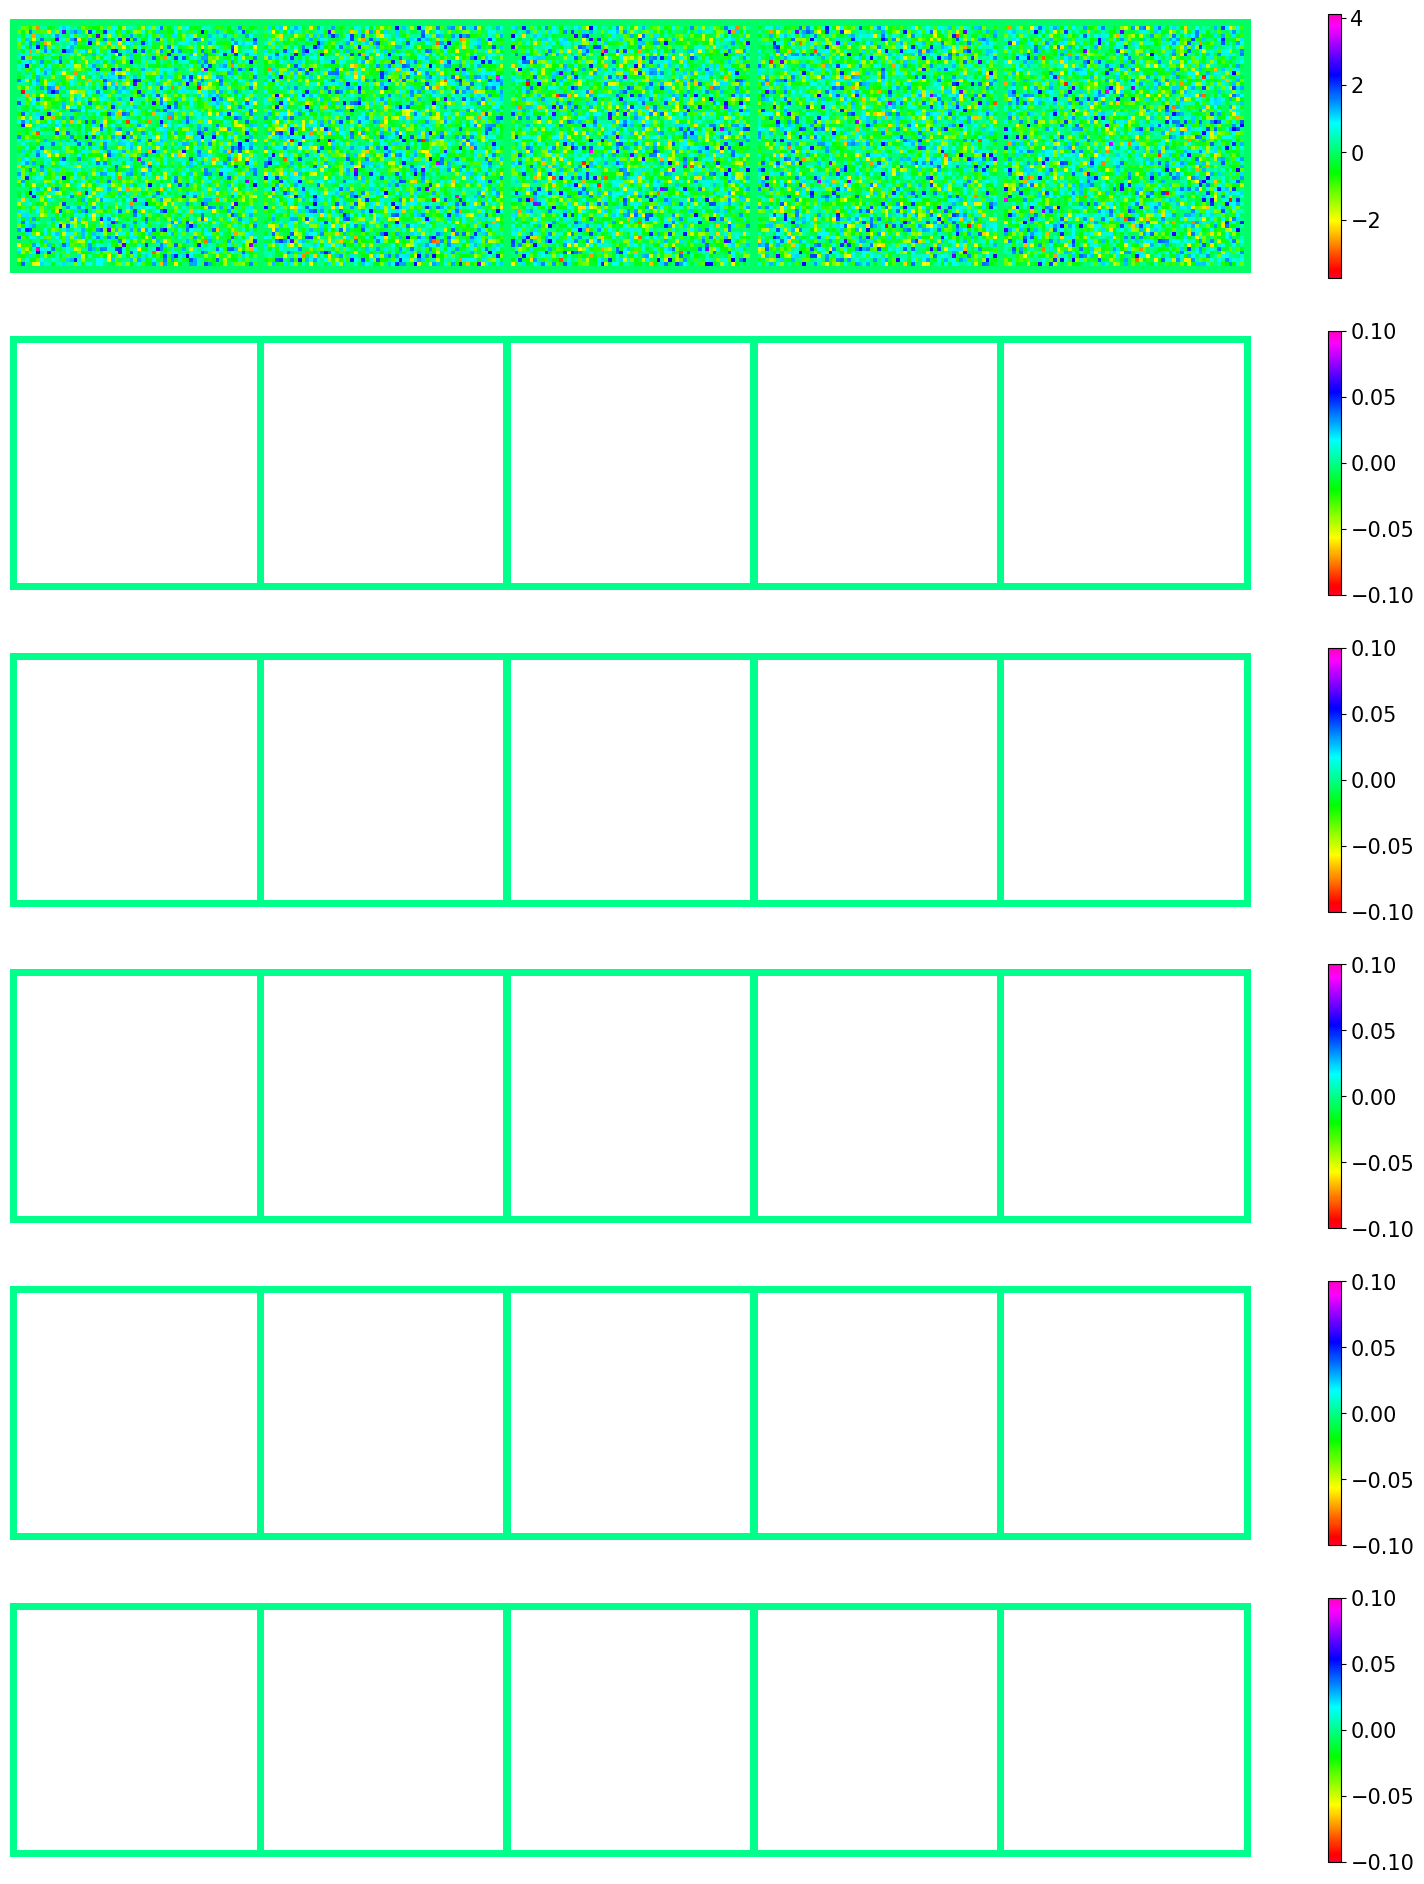

In [29]:
print_imgs_grid(ims, slice_=None, max_imgs_in_a_row=5,
                titles=[None,], plot_size=4, fontsize=15, is_2d=True)

In [30]:
for test_batch in dataset.train_dataloader:
    heads = batch['head']['data'].squeeze(-1).cuda()
    break
print(heads.shape)

torch.Size([64, 1, 64, 64])


In [31]:
ims = []
x = heads[:5] 
ims.append(x)
x = x.cuda()

In [32]:
for i in range(n_steps):
    t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
    with torch.no_grad():
        pred_noise = unet(x.float(), t.unsqueeze(0))
        x = p_xt(x, pred_noise, t.unsqueeze(0))
    if i%(50) == 0:
        ims.append(x.cpu())

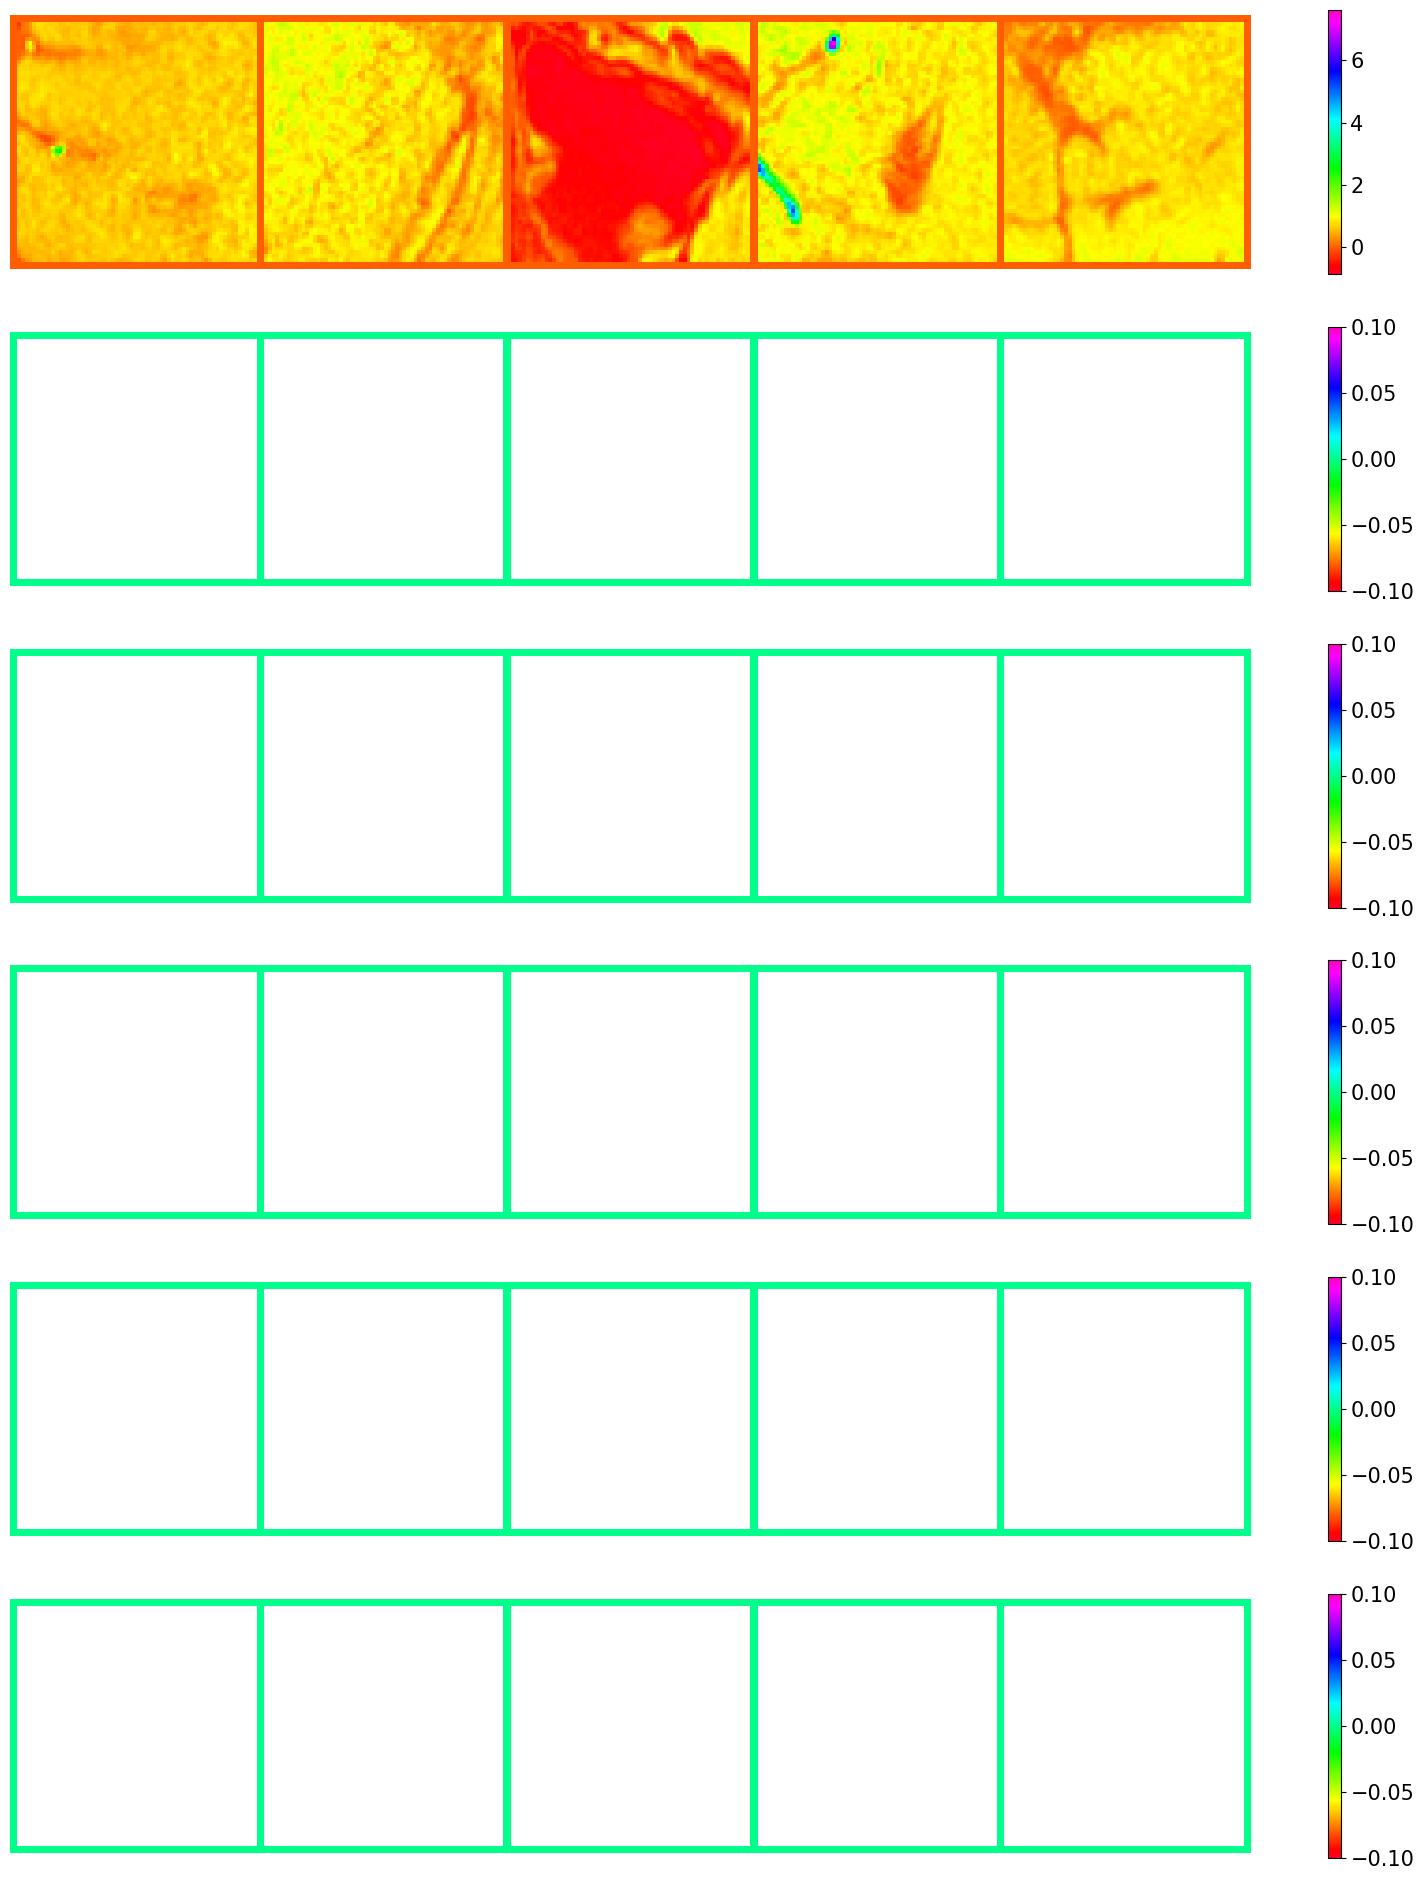

In [33]:
print_imgs_grid(ims, slice_=None, max_imgs_in_a_row=5,
                titles=[None,], plot_size=4, fontsize=15, is_2d=True)

**<h3> Real Images**

In [5]:
import numpy as np

import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import os
import matplotlib.pyplot as plt
import glob

import shutil

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

<h3> Delete tresh

In [6]:
root = '/home/msst/Documents/datasets/photo/ass/leigh'
files = sorted(glob.glob(os.path.join(root)+'/*.*'))

small = 0
norm = 0

for file in files:
    try:
        image = Image.open(file)
        if image.size[0]>128 and image.size[1]>128:
            norm+=1
        else:
            small+=1
            os.remove(file)
    except:
        os.remove(file)
        
print(norm)
print(small)


1815
0


In [11]:
img_height = 64
img_width = 64
channels = 3

def tensor2img(tensor):
    if len(tensor.shape) == 3:
        img = tensor.permute(1,2,0)
        return img
    else:
        raise RuntimeError("tensor2img: not a 3-dimention")

transforms_ = [
    transforms.Resize(int(img_height), Image.BICUBIC),
    transforms.RandomCrop((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        self.files = sorted(glob.glob(os.path.join(root)+'/*.*'))
        
    def  __getitem__(self, index):
        image = Image.open(self.files[index % len(self.files)])
        try:
            item = self.transform(image)
        except: 
            print(self.files[index % len(self.files)])
            os.remove(self.files[index % len(self.files)])
            image = Image.open(self.files[index+1 % len(self.files)])
            item = self.transform(image)
            
        return item
    
    def __len__(self):
        return len(self.files)

In [22]:
batch_size = 128
n_steps = 250
beta = torch.linspace(0.0001, 0.04, n_steps).cuda()
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

In [23]:
dataloader = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True),
    batch_size=batch_size, 
    shuffle=True,
    num_workers=8 
)

In [1]:
for batch in dataloader:    
    print_imgs_grid([batch,], slice_=None, max_imgs_in_a_row=5,
                titles=[None,], plot_size=2, fontsize=15, is_2d=True, is_color=True)
    break

NameError: name 'dataloader' is not defined

In [25]:
unet = UNet(image_channels=3, n_channels=32, n_blocks=2).cuda()

lr = 3e-4
optim = torch.optim.AdamW(unet.parameters(), lr=lr)

In [26]:
history = []
for epoch in tqdm(range(10)):
    losses = []
    for batch in dataloader:
        x0 = batch.cuda()
        t = torch.randint(0, n_steps, (batch.shape[0],), dtype=torch.long).cuda()
        xt, noise = q_xt_x0(x0, t)
        pred_noise = unet(xt.float(), t)
        loss = F.mse_loss(noise.float(), pred_noise)
        losses.append(loss.item())
        optim.zero_grad()
        loss.backward()
        optim.step()
    mean_loss = sum(losses)/len(losses)   
    print(mean_loss)
    history.append(mean_loss)  

 10%|████▍                                       | 1/10 [00:11<01:39, 11.01s/it]

0.7260530352592468


 20%|████████▊                                   | 2/10 [00:22<01:28, 11.11s/it]

0.32154276768366497


 30%|█████████████▏                              | 3/10 [00:33<01:18, 11.19s/it]

0.21979835927486419


 40%|█████████████████▌                          | 4/10 [00:44<01:06, 11.10s/it]

0.17655327320098876


 50%|██████████████████████                      | 5/10 [00:55<00:54, 10.92s/it]

0.15061544279257458


 60%|██████████████████████████▍                 | 6/10 [01:05<00:43, 10.83s/it]

0.12859673649072648


 70%|██████████████████████████████▊             | 7/10 [01:17<00:32, 10.99s/it]

0.11935395300388336


 80%|███████████████████████████████████▏        | 8/10 [01:27<00:21, 10.87s/it]

0.1202858105301857


 90%|███████████████████████████████████████▌    | 9/10 [01:38<00:10, 10.91s/it]

0.10939485430717469


100%|███████████████████████████████████████████| 10/10 [01:49<00:00, 10.93s/it]

0.1040394221742948


In [27]:
from utils import save_model, load_pretrainned
save_model(unet, '/home/msst/save_folder/saved_models', 'DiffusionReal2')
#load_pretrainned(unet, '/home/msst/save_folder/saved_models/DiffusionReal')

In [31]:
ims = []
x = torch.randn(1, 3, 64, 64) # Создадим рандомный шум
ims.append(x)
x = x.cuda()

for i in range(n_steps):
    t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
    with torch.no_grad():
        pred_noise = unet(x.float(), t.unsqueeze(0))
        x = p_xt(x, pred_noise, t.unsqueeze(0))
    if i%(50) == 0:
        ims.append(x.cpu())

ims.append(x.cpu())    

In [32]:
print(len(ims))

7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


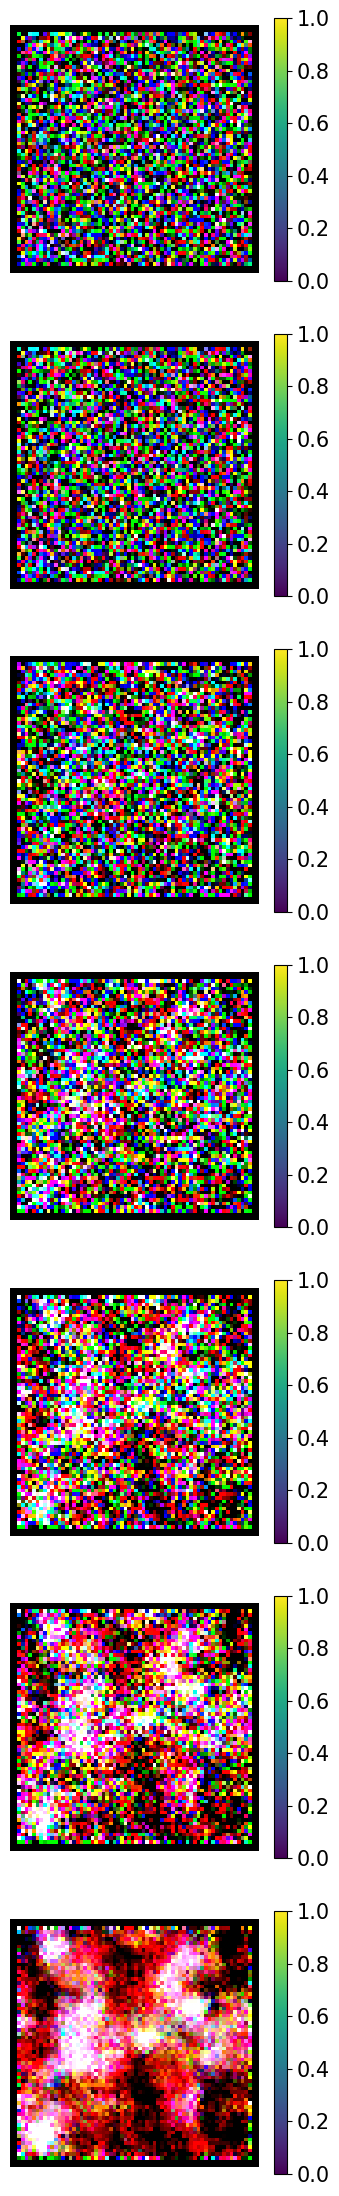

In [33]:
print_imgs_grid(ims, slice_=None, max_imgs_in_a_row=5,
                titles=[None,], plot_size=4, fontsize=15, is_2d=True, is_color=True)